# 数据加载和处理
学习用PyTorch工具加载和处理数据

## 1. 加载图像处理相关的包

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd 
from skimage import io, transform #scikit-image库，用于图像的IO和变换 
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore") # 忽略警告
plt.ion() # interactive mode

## 2. 下载数据集
faces这个数据集实际上是imagenet数据集标注为face的图片当中在dlib面部检测 (dlib’s pose estimation) 表现良好的图片，加下来要进行的是人脸面部姿态标注。数据集是按如下规则打包成的csv文件:

image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y 

0805personali01.jpg,27,83,27,98, ... 84,134 

1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

## 3. 读取数据集
将csv中的标注点数据读入(N，2)数组中，其中N是特征点的数量。

In [2]:
landmarks_frame = pd.read_csv('./data/faces/face_landmarks.csv')
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


展示图片和标注点：

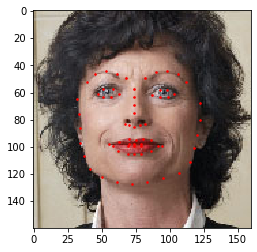

In [4]:
def show_landmarks(image, landmarks):
    """显示带有标注点的图片"""
    plt.imshow(image) #显示图片
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001) # pause a bit so that plots are updated
    
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),landmarks) #读取图片
plt.show()

### 4. 自定义数据集类

In [5]:
class FaceLandmarksDataset(Dataset): 
    """面部标记数据集."""
    
    def __init__(self, csv_file, root_dir, transform=None): 
        """
        csv_file(string):带注释的csv文件的路径。 
        root_dir(string):包含所有图像的目录。 
        transform(callable， optional):一个样本上的可用的可选变换 
        """
        self.landmarks_frame = pd.read_csv(csv_file) 
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


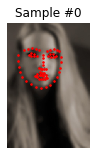

1 (500, 333, 3) (68, 2)


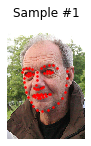

2 (250, 258, 3) (68, 2)


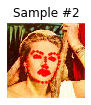

3 (434, 290, 3) (68, 2)


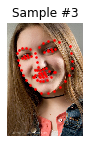

In [6]:
# 实例化数据类，遍历数据集
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')
fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1) 
    plt.tight_layout() 
    ax.set_title('Sample #{}'.format(i)) 
    ax.axis('off') 
    show_landmarks(**sample) #双星号参数是将传入的任意多个参数转为字典
    if i == 3: 
        plt.show()
        break

### 5. 自定义数据预处理类
- Rescale：缩放
- RandomCrop：随机裁剪
- ToTensor：将numpy格式的图片转成Torch tensor（需要交换坐标轴）

In [8]:
class Rescale(object): 
    """
    将样本中的图像重新缩放到给定大小。.
    Args:
        output_size(tuple或int):所需的输出大小。 如果是元组，则输出为与output_size匹配。 如果是int，则匹配较小的图像边缘到output_size保持纵横比相同。
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w)) #resize函数
        # h and w are swapped for landmarks because for images, x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

In [9]:
class RandomCrop(object):
    """
    随机裁剪样本中的图像.
    Args:
    output_size(tuple或int):所需的输出大小。 如果是int，方形裁剪。
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) 
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size) 
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left: left + new_w]  #自己实现的随机裁剪
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}

In [10]:
class ToTensor(object): 
    """
    将样本中的ndarrays转换为Tensors.
    """
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # 交换颜色轴因为numpy包的图片是: H * W * C，torch包的图片是: C * H * W
        image = image.transpose((2, 0, 1)) #tensor交换坐标轴
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

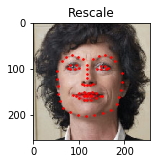

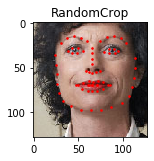

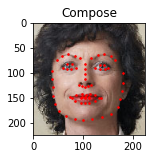

In [11]:
# 预处理的组合
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)]) #组合变换

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    plt.show()

In [13]:
# 在数据集上使用预处理
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/', 
                                           transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size()) 
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


### 6. 迭代数据集
相比for循环，迭代器torch.utils.data.DataLoader的好处在于可以：
- 批量处理数据 batch
- 打乱数据 shuffle
- 使用多线程multiprocessingworker 并行加载数据

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


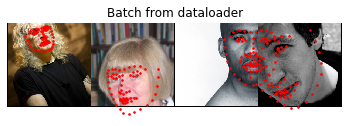

In [15]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4) #定义数据集迭代器

def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch) 
    im_size = images_batch.size(2) 
    grid_border_size = 2
    grid = utils.make_grid(images_batch) 
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size, landmarks_batch[i, :, 1].numpy() + grid_border_size, s=10, marker='.', c='r')
        plt.title('Batch from dataloader')
        
for i_batch, sample_batched in enumerate(dataloader): # 迭代数据集
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
    # 观察第4批次并停止。 
    if i_batch == 3: 
        plt.figure()
        show_landmarks_batch(sample_batched) 
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### 7. torchvision
torchvision包提供了常用的数据集类(datasets)和转换(transforms)。你可能不需要自己构造这些类。

In [17]:
import torch
from torchvision import transforms, datasets
data_transform = transforms.Compose([transforms.RandomSizedCrop(224), 
                                     transforms.RandomHorizontalFlip(), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train', transform=data_transform) #ImageFolder假定了数据集是以“分类标签/图片名“构造的
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset, batch_size=4, shuffle=True, num_workers=4)

FileNotFoundError: [Errno 2] No such file or directory: 'hymenoptera_data/train'